#Shape detection experiment [AlexNet, VGG19, ResNet152V2, DenseNet201]
The following Notebook intends to take a look at the detection and classification of a variable number of objects (with relative bounding boxes)in an image dataset using convolutional neural networks taken from the literature on the subject. The structure of this experiment is as follows:
___

- Premise

###Part I (common to all neural networks)
- Data generation
- Examples Visualization 
- Preprocessing
- ML Dataset preparation

###Part II
- Modelling Convolutional Neural Network
- Training and Tuning

###Part III
- Prediction analysis
- Conclusions
___

#Premise
The intention of this work is to test different neural networks taken from the scientific literature in the solution of the same task, that is the identification of different objects present in the same image.

In the first part I will dedicate myself to the construction of a 64x64 size dataset of synthetic images. These are images inside which I will insert rectangular, cross and pound shape objects of various sizes and colors in random positions. To make it more complex we consider just objects that have their background with a minimum difference in hue compared to the background of the image.

Together with the creation of the images I will develop the bounding boxes that enclose our objects, in order to have examples accompanied by our target values. at the end we will have a dataset with images each of which will contain from 1 to 4 objects of three shapes (o, +, #) with a dominant of different color (red, green, blue).

In [0]:
# we import some libraries that will be used during the project
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import drive
import h5py

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# general path 
path = '/content/drive/My Drive/'
# data path 
data_path = 'Colab_data/'

#Part I

##Data Generation
We create a simple image dataset. Each image will have a maximum size of '*side_dim* x *side_dim*' and will contain up to a maximum of '*n_bb*' objects (rectangles) with different shapes and shades of color. The size of each side will vary between an '*obj_min_dim*' to an '*obj_max_dim*'. 

Let's consider a background color and a variable color gradation of the objects ('*min_color* - *max_color*') for each RGB channel. The closer the color of the object to the background color, the lower the confidence level ('*Pc_th*') of our bounding boxes.

We will use 6 coordinates to define our bounding boxes: a '*cl*', wich indicate shape and color ('+r','+g','+b',','xr','xg','xb','or','og','ob'), a '*Pc*', which indicates the confidence level in the presence of an object; '*x*' and '*y*', for the spatial position of the top-left vertex and '*w*' and '*h*' for the extension (width and height).

We will also create an array containing the distance between the center of each object and the origin of the axes to sort the bounding boxes in the pre-processing phase and to solve a problem already encountered in previous experiments.

In [0]:
# number of dataset images 
n_imgs = 1000

# number of objects
n_bb = 3

# images side dimension
side_dim = 64 

# objects min/max side dimensions
obj_min_dim = 5
obj_max_dim = 15

# a dictionary with our classes
classes = { 0: '--',
            1: '+r',
            2: '+g',
            3: '+b',
            4: '#r',
            5: '#g',
            6: '#b',
            7: 'or',
            8: 'og',
            9: 'ob'}
            
# grey level of the background RGB = (bckg,bckg,bckg)
bckg = 200

# obj RGB colors thresholds
min_color = 1
max_color = 255

# Formula to establish image color level confidence: 
# Pc = min(1, round(max(0, abs(shape_bckg-bckg)-8) ** (5/9))/10 )
# confidence threshold
Pc_th = .4

Let's define a python method for creating images, bounding boxes and the distance of each object from the origin of the axes:

In [0]:
# method to create objects in images and relative bounding boxes
def new_dataset(n_imgs, 
                n_bb, 
                side_dim, 
                obj_min_dim, 
                obj_max_dim, 
                min_color, 
                max_color, 
                bckg, 
                Pc_th):
    '''
    Creation of objects in images and relative bounding boxes

    Arguments:
    n_imgs -- scalar, number of images
    n_bb -- scalar, number of Bounding Boxes
    side_dim -- size of image sides
    obj_min_dim -- scalar, minimum object size
    obj_max_dim -- scalar, maximum object size
    min_color - scalar, minimum color threshold
    max_color - scalar, maximum color threshold
    bckg - scalar, background color

    Returns:
    imgs -- np.array(n_imgs, side_dim, side_dim), images of our dataset
    bounding_boxes -- np.array(n_imgs, n_bb, 6), bounding boxes for each image
    distance -- np.array(n_imgs, n_bb), distance from origin for each Bounding box
    '''
    # inizialization of images with a light gray color
    imgs = np.ones((n_imgs, side_dim, side_dim, 3), dtype = ('uint8')) * bckg

    # inizialization of bounding boxes
    bounding_boxes = np.zeros((n_imgs, n_bb, 6))

    # inizialization of origin distance array
    distance = np.zeros((n_imgs, n_bb))

    # objects creation and evaluation of distance from origin
    for img_number in range(n_imgs):
        for i_ogg in range(n_bb):
            # shapes:  0 = '+'  /  1 = 'x'  /  2 = '#'
            shape = np.random.randint(3) * 3

            w = np.random.randint(obj_min_dim, obj_max_dim)
            if w % 2 == 0: # we want odd numbers
                w += 1
            h = np.random.randint(obj_min_dim, obj_max_dim)
            if h % 2 == 0: # we want odd numbers
                h += 1

            x = np.random.randint(0, side_dim - w)
            y = np.random.randint(0, side_dim - h)

            R = (np.random.randint(min_color, max_color))
            G = (np.random.randint(min_color, max_color))
            B = (np.random.randint(min_color, max_color))

            shape_bckg = round(R+B+G)/3
            # initialize background shape color
            dominant_color = [shape_bckg] * 3

            # dominant color
            if R >= G and R >= B:
                dominant_color[0] = R
                cl = shape + 1
            elif G >= R and G >= B:
                dominant_color[1] = G
                cl = shape + 2
            else:
                dominant_color[2] = B
                cl = shape + 3

            # we avoid creating objects with no dominant color (tolerance 32)
            if max(R, G, B) - shape_bckg < 32:
                # no dominant color objects have no dimensions,
                # no bounding boxes and max distance from axes
                Pc = 0.  # for the moment we use for all target value Pc = 1
                bounding_boxes[img_number, i_ogg] = [0, Pc, 0, 0, 0, 0]
                distance[img_number, i_ogg] = np.sqrt(np.square(side_dim) * 2)

            # we avoid creating objects that overlap with others
            elif np.mean(imgs[img_number, y:y + h, x:x + w, :]) != bckg:
                # overlapping objects have no dimensions,
                # no bounding boxes and max distance from axes
                Pc = 0.  # for the moment we use for all target value Pc = 1
                bounding_boxes[img_number, i_ogg] = [0, Pc, 0, 0, 0, 0]
                distance[img_number, i_ogg] = np.sqrt(np.square(side_dim) * 2)

            else:
                imgs[img_number, y:y + h, x:x + w, :] = shape_bckg

                # we create a +
                if shape == 0:
                    imgs[img_number, y + h//2, x:x + w, :] = dominant_color
                    imgs[img_number, y: y + h, x + w//2, :] = dominant_color

                # we create a #
                elif shape == 3:
                    x_1 = x + (w // 3)
                    x_2 = x + ((w*2)// 3)
                    y_1 = y + (h // 3)
                    y_2 = y + ((h*2)// 3)
                    imgs[img_number, y_1, x:x + w] = dominant_color
                    imgs[img_number, y_2, x:x + w] = dominant_color
                    imgs[img_number, y:y+ h, x_1] = dominant_color
                    imgs[img_number, y:y+ h, x_2] = dominant_color

                # we create a o
                else:
                    x_from = x + (w // 3)
                    x_to = x + round(w / 3 * 2)
                    y_from = y + (h // 3)
                    y_to = y + round(h / 3 * 2)
                    imgs[img_number, y_from, x_from:x_to] = dominant_color
                    imgs[img_number, y_from:y_to, x_to] = dominant_color
                    imgs[img_number, y_from:y_to, x_from] = dominant_color
                    imgs[img_number, y_to, x_from:x_to+1] = dominant_color

                # we establish the degree of confidence of the object on the basis of
                # how dark it is in terms of black and white (sum of the RGB channels)
                Pc = min(1, round(max(0, abs(shape_bckg-bckg)-8) ** (5/9))/10 )

                # we avoid to create bounding boxes for examples under Pc_th
                if Pc < Pc_th:
                  bounding_boxes[img_number, i_ogg] = [0, 0.1, 0, 0, 0, 0]
                  distance[img_number, i_ogg] = np.sqrt(np.square(side_dim) * 2)

                else: 
                  # we generate relative bounding boxes
                  bounding_boxes[img_number, i_ogg] = [cl, 1, x, y, w, h]

                  # and calculate the distance from the origin for each Bounding Box
                  distance[img_number, i_ogg] = np.sqrt(np.square(x + (w / 2)) + np.square(y + (h / 2)))
                  if (x + (w / 2)) < (y + (h / 2)):
                    # to give an extra order element we differenciate object 
                    # above and below the diagonal y = x
                    distance[img_number, i_ogg] = -distance[img_number, i_ogg]


    return imgs, bounding_boxes, distance

##Data Creation
Now we use our new method. 


In [0]:
# creation of images, Bounding Boxes and an origin distance to order BB
imgs, bounding_boxes, distance = new_dataset( n_imgs, 
                                              n_bb, 
                                              side_dim, 
                                              obj_min_dim, 
                                              obj_max_dim, 
                                              min_color, 
                                              max_color,
                                              bckg,
                                              Pc_th)

In [7]:
# Let's look at the size of the Numpy arrays for images and bboxes 
print('Dimension of images array:', imgs.shape)
print('Dimension of BBoxes array:', bounding_boxes.shape)
print('Dimension of distance array:', distance.shape)

Dimension of images array: (1000, 64, 64, 3)
Dimension of BBoxes array: (1000, 3, 6)
Dimension of distance array: (1000, 3)


In [8]:
# objects created above and below our Pc_th
above_pc_obj = np.count_nonzero(bounding_boxes[:,:,1] == 1)
below_pc_obj = np.count_nonzero(bounding_boxes[:,:,1] == .1)
no_obj = (n_imgs * n_bb) - (above_pc_obj + below_pc_obj)
print('Obj above Pc_th:', above_pc_obj)
print('Obj below Pc_th:', below_pc_obj)
print('Obj not created:', no_obj)

Obj above Pc_th: 2101
Obj below Pc_th: 180
Obj not created: 719


...and we save dataset in a h5 file in order to reproduce our experiment in the future.

In [0]:
data_images = 'images_' + str(n_imgs//1000) + 'k_' + str(n_bb) + 'bb.h5'

In [10]:
# save h5 file to store X_Y_datasets
imgs_h5f = h5py.File(path + data_path + data_images, 'w')

imgs_h5f.create_dataset('imgs', data=imgs)
imgs_h5f.create_dataset('bounding_boxes', data=bounding_boxes)
imgs_h5f.create_dataset('distance', data=distance)

<HDF5 dataset "distance": shape (1000, 3), type "<f8">

In [0]:
imgs_h5f.close()

##Examples visualization


We create a method to visualize some random examples of our dataset with relative bounding boxes and distances. 

In [0]:
# methode plot image with bounding boxes or distance
def visualize_preprocess(ax, img, dist, bboxes, Pc_th):
    """
    Arguments:
    ax -- plot image
    img -- np.array(32,32,3), an image
    dist -- np.array(4), objects distance from origin
    bboxes -- np.array(4,5), predicted bounding boxes
    Pc_th - scalar, obj level of confidence threshold

    Returns:
    None
    """
    side_dim = img.shape[0]

    # We look at the objects contained in it...
    ax.imshow(img, origin='upper', extent=[0, side_dim, side_dim, 0])
    n_bb = bboxes.shape[0]

    if np.any(dist is None):
        # ...and the bounding boxes predicted by the algorithm
        for j in range(n_bb):
            [cl, Pc, x, y, w, h] = bboxes[j]
            if Pc < Pc_th:  # we do not consider objects below the confidence threshold
                continue
            else:
                rect = patches.Rectangle((x, y), w, h, ec='r', lw='1', fc='none')
                dida = classes[int(cl)] + ' ' + str(Pc) 
                plt.annotate(dida, (x + w + 0.8, y + 0.8), color='r')
            ax.add_patch(rect)

    else:
        for j in range(n_bb):
            [cl, Pc, x, y, w, h] = bboxes[j]
            if Pc < Pc_th:  # we do not consider objects below the confidence threshold
                continue
            else:
                line = patches.Arrow(0, 0, x + (w / 2), y + (h / 2), .3, ec='r')
                ax.add_patch(line)
                dida = 'dist: ' + '{:0.1f}'.format(dist[j])
                plt.annotate(dida, (x + w + 0.8, y + 0.8), color='r')


Let's check how our examples are, let's visualize them with our new method.

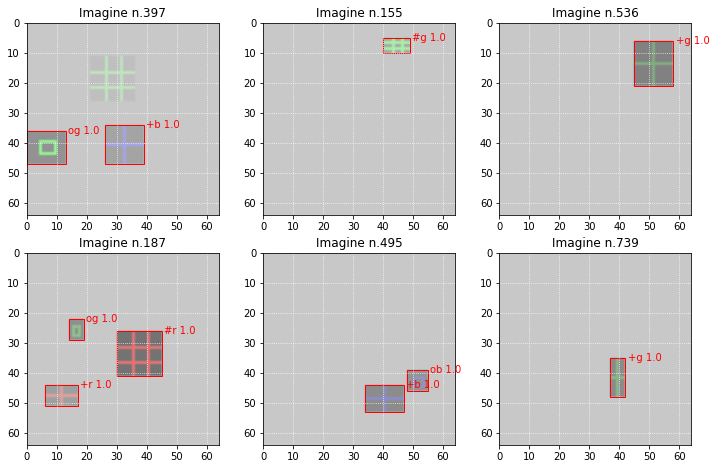

In [13]:
# We take to observe n_visual random images of our dataset and the relative bounding boxes 
n_visual = 6
rand_example = np.zeros((n_visual,), dtype=int)

fig = plt.figure(figsize=(12, 12))
for i in range(n_visual):
    # We take a random image of our training set
    rand_example[i] = np.random.randint(n_imgs)

    # We visualize it
    ax = fig.add_subplot((n_visual // 3) + 1, 3, i + 1)
    ax.grid( which='both', color='w', linestyle=':')
    plt.xticks(np.arange(0, side_dim, step=10))

    ax.set_title('Imagine n.' + str(rand_example[i]))
    visualize_preprocess(ax,
                          imgs[rand_example[i]],
                          None,
                          bounding_boxes[rand_example[i]],
                          Pc_th)
plt.show()

To be clear on what appears to us, consider the first example (image 735). In it we have two object identified with the bounding boxes and one unidentified. This depends on the background color of the image too close to the background color of the unidentified objects (our degree of confidence under Pc_th threshold).

In the second image we only have two objects, the third was not created probably because it risked overlapping one of the previous ones. As, on the other hand, happens in the third and fifth images where we have, respectively 2 and 1 objects with relative bounding boxes.

Now let's visualize them again showing the distance from the origin of the contained objects instead of their bounding boxes.

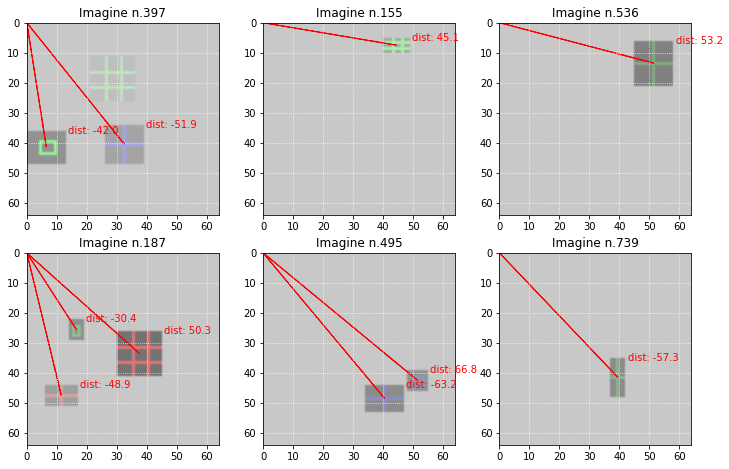

In [14]:
# We look at the images again, this time highlighting the distance of the objects from the origin ...
fig = plt.figure(figsize=(12,12))

for i in range(n_visual):
    # We visualize distance
    ax = fig.add_subplot((n_visual // 3) + 1, 3, i + 1)
    ax.grid( which='both', color='w', linestyle=':')
    plt.xticks(np.arange(0, side_dim, step=10))

    ax.set_title('Imagine n.' + str(rand_example[i]))
    visualize_preprocess(ax,
                          imgs[rand_example[i]],
                          distance[rand_example[i]],
                          bounding_boxes[rand_example[i]],
                          Pc_th) 
plt.show()

In [15]:
# Look at example bounding boxes
example = 735
print('bounding boxes for image', example, 'are:')
print(bounding_boxes[example])
print('relative distance from origin are: ', distance[example])

bounding boxes for image 735 are:
[[ 9.  1. 26. 21. 13. 15.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
relative distance from origin are:  [43.22614949 90.50966799 90.50966799]


As we said if we look at the three objects in the figure taken as an example, two have a Pc confidence 1, the other has not a sufficient color gradation and for it we have not created the related bounding boxing.

##Preprocessing
###Bounding boxes sorting


We reordered every bounding boxes of an image based on the correspondent object distance from the origin of axes. As we found in another experiment ([find it here on github](https://github.com/MarcoFosci/Shape_Detection/blob/master/Shape_Detection_1.4_.ipynb)), this greatly simplifies the computational work of our neural network.

In [0]:
# bounding boxes sorting based on distance from the origin
def order_bb(bounding_boxes, distance):   
    '''
    Arguments:
    bounding_boxes -- np.array(N_imgs, N_bb, 6), bounding boxes for each image
    distance -- np.array(N_imgs, N_bb), distance from origin for each Bounding box
    Returns:
    bboxes -- np.array(N_imgs, N_bb, 5), bounding boxes ordered
    '''

    n_imgs = bounding_boxes.shape[0]
    n_bb = bounding_boxes.shape[1]

    order = np.zeros((n_imgs, n_bb), dtype=int)
    bboxes = np.zeros(bounding_boxes.shape)

    for i in range(n_imgs):
        order[i] = np.argsort(distance[i])
        for j in range(n_bb):
            bboxes[i, j] = (bounding_boxes[i, order[i, j]])

    return bboxes

In [0]:
bb_ordered = order_bb(bounding_boxes, distance) 

In [0]:
# del some variables to save memory
del bounding_boxes, distance

In [19]:
# Look again at example bounding boxes
print('bounding boxes for image', example, 'are:')
print(bb_ordered[example])

bounding boxes for image 735 are:
[[ 9.  1. 26. 21. 13. 15.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


###Some more visualization


In [20]:
# now we consider classes and confidences of ours objects
obj_classes = bb_ordered[:,:,0]
obj_confidences = bb_ordered[:,:,1]

obj_classes.shape, obj_confidences.shape

((1000, 3), (1000, 3))

In [21]:
# to summarize our classes
list(classes.values())

['--', '+r', '+g', '+b', '#r', '#g', '#b', 'or', 'og', 'ob']

Just to get a clearer idea of our dataset let's take a further look at the distribution of the classes. 

As we see the classes are equally distributed, except for the class zero ('0') where we have grouped the objects not created (because they overlapped wiht other) and the objects with a level of confidence equal to zero (because they got confused with the background color). 
After sorting, they mostly ended up in the third and second bounding boxes.

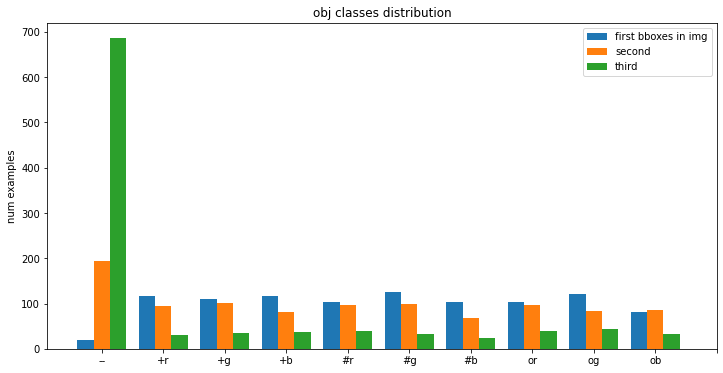

In [22]:
# Plot Histogram obj classes distribution
bins = np.arange(0, 11, 1)
fig = plt.figure(figsize=(12,6))
plt.hist(obj_classes, bins=bins-0.5)
plt.gca().set(title='obj classes distribution', ylabel='num examples')
plt.xticks(ticks=bins, labels=list(classes.values()))
plt.legend(['first bboxes in img','second','third'])
plt.show()

In [23]:
zero = np.count_nonzero(obj_classes == 0) / (n_bb*n_imgs)
other = np.count_nonzero(obj_classes > 0) / (9*n_bb*n_imgs)
print('Weighted class zero elements out of the total:', zero)
print('other classes weighted', other)

Weighted class zero elements out of the total: 0.2996666666666667
other classes weighted 0.07781481481481481


Let's also take a look at the distribution of confidence over ours examples. As above we have a large number of examples with confidence = 0 (these are not created objects), a small number with confidence = 0.1 (created obj with Pc < Pc_th), and the great part of the examples with confidence = 1 (all obj with Pc >= Pc_th).

The latter, after sorting, are mainly inserted in the first and second bounding boxes of each image - sometimes even in the third if three objects have been created with Pc> = Pc_th.

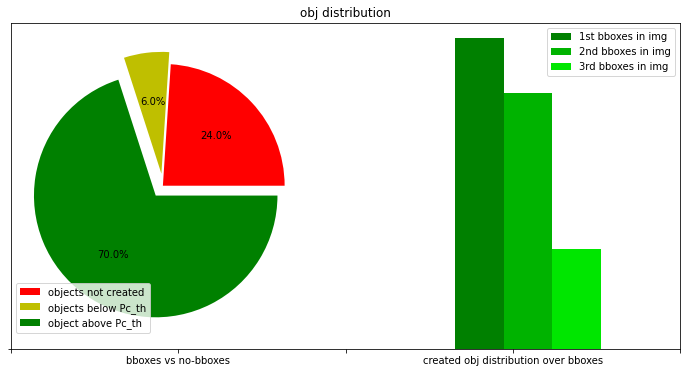

In [24]:
# Plot Histogram with obj confidence distribution
fig = plt.figure(figsize=(12,6))
plt.gca().set(title='obj distribution')
plt.xticks([0,1,2,3,4], ['','bboxes vs no-bboxes', '','created obj distribution over bboxes',''])
plt.yticks([0], [''])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# pie with objects above_pc_obj, below_pc_obj and no_obj
explode = [0, .1, .1]
ax1.pie([no_obj, below_pc_obj, above_pc_obj], 
        autopct='%1.1f%%', explode=explode, colors=['r','y','g'])
ax1.legend(['objects not created','objects below Pc_th','object above Pc_th'])

# histogram with distribution obj over bounding boxes
ax2.hist(x=obj_confidences, bins=[.8, 1.1], color=[[.0, .5, .0], [.0, .7, .0], [.0, .9, .0]])
ax2.legend(['1st bboxes in img','2nd bboxes in img','3rd bboxes in img'])
ax2.set_xlim(.7, 1.2)
ax2.axis('off')

plt.show()

In [25]:
# just a check - confidence zero is the same of classes '0' elements
cf_zero = np.count_nonzero(obj_confidences == 0) / (n_bb*n_imgs)
cf_no_dected = np.count_nonzero(obj_confidences == 0.1) / (n_bb*n_imgs)
cf_one = np.count_nonzero(obj_confidences == 1) / (n_bb*n_imgs)
print('Weighted obj with  0 confidence out of the total:', cf_zero)
print('Weighted obj with .1 confidence out of the total:', cf_no_dected)
print('Weighted obj with  1 confidence out of the total:', cf_one, '\n')

Weighted obj with  0 confidence out of the total: 0.23966666666666667
Weighted obj with .1 confidence out of the total: 0.06
Weighted obj with  1 confidence out of the total: 0.7003333333333334 



In [0]:
# del some variables to save memory
del obj_classes, obj_confidences

##Machine Learning Dataset preparation

Let's start thinking in terms of Machine Learning.
So we normalize our images by centering them on the origin and dividing them by the standard deviation.









In [0]:
def create_XY(imgs, bb_ordered):
  """
  We create dataset for Machine Learning alghoritm in term 
  of X (examples) and Y (targets)
  """
  # we compute images mean and image standar deviation
  imgs_mean = np.mean(imgs)
  imgs_std = np.std(imgs)

  # We normalize our images 
  X = imgs - imgs_mean  # centering
  X /= imgs_std         # scaling
  print('X shape: ',X.shape, '---- Average value: ', imgs_mean, '---- Standard deviation:', np.std(imgs))

  # ...and we reshape target value
  Y = bb_ordered.reshape(n_imgs, -1) 
  print('Y shape: ',Y.shape)
  return X, Y, imgs_mean, imgs_std

In [28]:
X, Y, imgs_mean, imgs_std = create_XY(imgs, bb_ordered)

X shape:  (1000, 64, 64, 3) ---- Average value:  196.3708145345052 ---- Standard deviation: 18.01074566898894
Y shape:  (1000, 18)


In [0]:
# del some variables to save memory
del imgs, bb_ordered

Below we see the shape of our X values and we observe one of our Y target values.

In [30]:
print('Images example', i, 'has shape:\n', X[example].shape, '\n')
print('...and the target values Y are:\n', Y[example])

Images example 5 has shape:
 (64, 64, 3) 

...and the target values Y are:
 [ 9.  1. 26. 21. 13. 15.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

#A larger dataset splitted in blocks
We create a more efficient pipeline using a larger dataset divided into blocks (and using the division into blocks to work with a cross Validation).

###First step: let's create the dataset divided into X Y

In [0]:
# Change number of examples 
n_imgs = 80000

In [34]:
# creation of images, Bounding Boxes and an origin distance to order BB
imgs, bounding_boxes, distance = new_dataset( n_imgs, 
                                              n_bb, 
                                              side_dim, 
                                              obj_min_dim, 
                                              obj_max_dim, 
                                              min_color, 
                                              max_color,
                                              bckg,
                                              Pc_th)

bb_ordered = order_bb(bounding_boxes, distance) 

# del some variables to save memory
del bounding_boxes, distance

X, Y, imgs_mean, imgs_std = create_XY(imgs, bb_ordered)

# del some variables to save memory
del imgs, bb_ordered

X shape:  (80000, 64, 64, 3) ---- Average value:  196.25516473286947 ---- Standard deviation: 18.40648625469224
Y shape:  (80000, 18)


We have a homogeneous dataset of the N_imgs elements that we now share in Training set and Test set in relation 85% and 15%.

###Examples for the Testset
Now let's save aside the examples that we will use as Test set at the end of the training to verify the goodness of our results.

In [0]:
percentage_testsetsize = 0
testset_size = int(percentage_testsetsize*n_imgs)
start_testset = n_imgs - testset_size

In [36]:
print('Number of examples for Test set:', testset_size)

Number of examples for Test set: 0


In [37]:
# trainingset and testset filenames
trainingset_name = 'XYdata_' + str(start_testset//1000) + 'k_' + str(n_bb) + 'bb_.h5'
testset_name = 'XYdata_' + str(testset_size//1000) + 'k_' + str(n_bb) + 'bb_testset.h5'
print('Trainingset name:', trainingset_name)
print('Testset name: ', testset_name)

Trainingset name: XYdata_80k_3bb_.h5
Testset name:  XYdata_0k_3bb_testset.h5


In [0]:
testset_h5f = h5py.File(path + data_path + testset_name, 'w')

In [37]:
testset_h5f.create_dataset('X_test', data=X[start_testset:])
testset_h5f.create_dataset('Y_test', data=Y[start_testset:])
testset_h5f.create_dataset('imgs_mean', data = imgs_mean)
testset_h5f.create_dataset('imgs_std', data = imgs_std)
print('Testset saved')

Testset saved


In [0]:
testset_h5f.close()

In [0]:

# save h5 file to store X_Y_trainingsets
xy_h5f = h5py.File(path + data_path + trainingset_name, 'w')

xy_h5f.create_dataset('X_train', data=X[:start_testset])
xy_h5f.create_dataset('Y_train', data=Y[:start_testset])
xy_h5f.create_dataset('imgs_mean', data = imgs_mean)
xy_h5f.create_dataset('imgs_std', data = imgs_std)

xy_h5f.close()


###Split and save Trainingset
We divide our training set into six parts and save each part separately

In [0]:
num_split = 10
step = start_testset//num_split

In [39]:
print('Number of examples for Training set:', start_testset)
print('Number of blocks:', num_split)
print('Size of each block:', step)

Number of examples for Training set: 80000
Number of blocks: 10
Size of each block: 8000


In [0]:
xy_h5f = h5py.File(path + data_path + trainingset_name, 'w')

In [41]:
block = 1
for i in range(step, start_testset+step , step):
  if block == num_split:
    end_block = start_testset
  else:
    end_block = i 

  print('Examples from', i - step, 'to', end_block, 'saved in block', block, )
  xy_h5f.create_dataset('X_train'+str(block)+'_block', data=X[i-step:end_block])
  xy_h5f.create_dataset('Y_train'+str(block)+'_block', data=Y[i-step:end_block])
  block += 1

xy_h5f.create_dataset('num_split', data = num_split)
xy_h5f.create_dataset('imgs_mean', data = imgs_mean)
xy_h5f.create_dataset('imgs_std', data = imgs_std)

print('\nSaved ', start_testset, 'examples splitted in', num_split,'blocks')

Examples from 0 to 8000 saved in block 1
Examples from 8000 to 16000 saved in block 2
Examples from 16000 to 24000 saved in block 3
Examples from 24000 to 32000 saved in block 4
Examples from 32000 to 40000 saved in block 5
Examples from 40000 to 48000 saved in block 6
Examples from 48000 to 56000 saved in block 7
Examples from 56000 to 64000 saved in block 8
Examples from 64000 to 72000 saved in block 9
Examples from 72000 to 80000 saved in block 10

Saved  80000 examples splitted in 10 blocks


In [0]:
xy_h5f.close()